In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [8]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dloss, glossQ, dlossQ

In [15]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [16]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, 
                                           d_learning_rate=d_learning_rate)

In [17]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [18]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [19]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [20]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [21]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dloss, glossQ, dlossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.g_lossQ, model.d_lossQ,
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.targetQs: targetQs, 
                                                                       model.rates: rates})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:20.0000 R:20.0000 rate:0.0400 gloss:0.6463 dloss:1.4007 glossQ:1.0063 dlossQ:0.8000 exploreP:0.9980
Episode:1 meanR:21.0000 R:22.0000 rate:0.0440 gloss:0.6378 dloss:1.3950 glossQ:1.0060 dlossQ:0.8171 exploreP:0.9959
Episode:2 meanR:17.6667 R:11.0000 rate:0.0220 gloss:0.6186 dloss:1.3909 glossQ:1.0087 dlossQ:0.8559 exploreP:0.9948
Episode:3 meanR:19.7500 R:26.0000 rate:0.0520 gloss:0.6290 dloss:1.3904 glossQ:1.0079 dlossQ:0.8456 exploreP:0.9922
Episode:4 meanR:20.2000 R:22.0000 rate:0.0440 gloss:0.6103 dloss:1.3848 glossQ:1.0063 dlossQ:0.8643 exploreP:0.9901
Episode:5 meanR:18.8333 R:12.0000 rate:0.0240 gloss:0.5852 dloss:1.3790 glossQ:1.0105 dlossQ:0.8750 exploreP:0.9889
Episode:6 meanR:18.4286 R:16.0000 rate:0.0320 gloss:0.5778 dloss:1.3770 glossQ:1.0136 dlossQ:0.9154 exploreP:0.9873
Episode:7 meanR:17.6250 R:12.0000 rate:0.0240 gloss:0.5750 dloss:1.3768 glossQ:1.0111 dlossQ:0.8923 exploreP:0.9861
Episode:8 meanR:17.6667 R:18.0000 rate:0.0360 gloss:0.5884 dloss:1.3774 

Episode:71 meanR:26.3750 R:67.0000 rate:0.1340 gloss:0.4382 dloss:1.3404 glossQ:1.0289 dlossQ:1.1904 exploreP:0.8288
Episode:72 meanR:26.3014 R:21.0000 rate:0.0420 gloss:0.4371 dloss:1.3389 glossQ:1.0179 dlossQ:1.1778 exploreP:0.8271
Episode:73 meanR:26.2568 R:23.0000 rate:0.0460 gloss:0.4446 dloss:1.3363 glossQ:1.0222 dlossQ:1.1754 exploreP:0.8252
Episode:74 meanR:26.1200 R:16.0000 rate:0.0320 gloss:0.4290 dloss:1.3368 glossQ:1.0232 dlossQ:1.1771 exploreP:0.8239
Episode:75 meanR:26.4737 R:53.0000 rate:0.1060 gloss:0.4347 dloss:1.3369 glossQ:1.0248 dlossQ:1.1829 exploreP:0.8196
Episode:76 meanR:26.5455 R:32.0000 rate:0.0640 gloss:0.4268 dloss:1.3396 glossQ:1.0217 dlossQ:1.1895 exploreP:0.8170
Episode:77 meanR:26.7692 R:44.0000 rate:0.0880 gloss:0.4309 dloss:1.3368 glossQ:1.0239 dlossQ:1.1709 exploreP:0.8134
Episode:78 meanR:26.7342 R:24.0000 rate:0.0480 gloss:0.4230 dloss:1.3327 glossQ:1.0230 dlossQ:1.1752 exploreP:0.8115
Episode:79 meanR:26.6875 R:23.0000 rate:0.0460 gloss:0.4211 dlos

Episode:141 meanR:46.9200 R:212.0000 rate:0.4240 gloss:0.4358 dloss:1.3428 glossQ:1.0226 dlossQ:1.1508 exploreP:0.5699
Episode:142 meanR:48.3600 R:158.0000 rate:0.3160 gloss:0.4313 dloss:1.3432 glossQ:1.0235 dlossQ:1.1578 exploreP:0.5611
Episode:143 meanR:48.3500 R:13.0000 rate:0.0260 gloss:0.4328 dloss:1.3357 glossQ:1.0220 dlossQ:1.1441 exploreP:0.5604
Episode:144 meanR:49.2300 R:114.0000 rate:0.2280 gloss:0.4337 dloss:1.3422 glossQ:1.0222 dlossQ:1.1500 exploreP:0.5542
Episode:145 meanR:49.1300 R:32.0000 rate:0.0640 gloss:0.4291 dloss:1.3463 glossQ:1.0219 dlossQ:1.1443 exploreP:0.5525
Episode:146 meanR:49.7500 R:73.0000 rate:0.1460 gloss:0.4307 dloss:1.3405 glossQ:1.0237 dlossQ:1.1509 exploreP:0.5485
Episode:147 meanR:50.0600 R:66.0000 rate:0.1320 gloss:0.4313 dloss:1.3392 glossQ:1.0234 dlossQ:1.1550 exploreP:0.5450
Episode:148 meanR:50.7900 R:86.0000 rate:0.1720 gloss:0.4247 dloss:1.3398 glossQ:1.0249 dlossQ:1.1415 exploreP:0.5404
Episode:149 meanR:51.9000 R:140.0000 rate:0.2800 glos

Episode:210 meanR:142.3900 R:191.0000 rate:0.3820 gloss:0.4467 dloss:1.3591 glossQ:1.0250 dlossQ:0.9971 exploreP:0.1787
Episode:211 meanR:145.0400 R:277.0000 rate:0.5540 gloss:0.4427 dloss:1.3637 glossQ:1.0230 dlossQ:0.9975 exploreP:0.1741
Episode:212 meanR:149.2300 R:432.0000 rate:0.8640 gloss:0.4494 dloss:1.3666 glossQ:1.0217 dlossQ:0.9550 exploreP:0.1671
Episode:213 meanR:150.5400 R:161.0000 rate:0.3220 gloss:0.4498 dloss:1.3696 glossQ:1.0219 dlossQ:0.9388 exploreP:0.1646
Episode:214 meanR:150.0500 R:168.0000 rate:0.3360 gloss:0.4540 dloss:1.3626 glossQ:1.0229 dlossQ:0.9300 exploreP:0.1620
Episode:215 meanR:149.9700 R:99.0000 rate:0.1980 gloss:0.4486 dloss:1.3806 glossQ:1.0208 dlossQ:0.9345 exploreP:0.1606
Episode:216 meanR:152.3100 R:258.0000 rate:0.5160 gloss:0.4549 dloss:1.3695 glossQ:1.0224 dlossQ:0.8898 exploreP:0.1567
Episode:217 meanR:156.2000 R:408.0000 rate:0.8160 gloss:0.4556 dloss:1.3692 glossQ:1.0227 dlossQ:0.8905 exploreP:0.1509
Episode:218 meanR:157.2800 R:135.0000 rat

Episode:279 meanR:272.9000 R:250.0000 rate:0.5000 gloss:0.5350 dloss:1.3644 glossQ:1.0458 dlossQ:0.6388 exploreP:0.0320
Episode:280 meanR:274.8300 R:500.0000 rate:1.0000 gloss:0.5360 dloss:1.3682 glossQ:1.0435 dlossQ:0.6218 exploreP:0.0309
Episode:281 meanR:278.5600 R:500.0000 rate:1.0000 gloss:0.5333 dloss:1.3694 glossQ:1.0426 dlossQ:0.6295 exploreP:0.0299
Episode:282 meanR:280.3000 R:317.0000 rate:0.6340 gloss:0.5254 dloss:1.3659 glossQ:1.0419 dlossQ:0.6400 exploreP:0.0293
Episode:283 meanR:283.4700 R:500.0000 rate:1.0000 gloss:0.5212 dloss:1.3671 glossQ:1.0471 dlossQ:0.6392 exploreP:0.0283
Episode:284 meanR:286.5500 R:500.0000 rate:1.0000 gloss:0.5274 dloss:1.3641 glossQ:1.0453 dlossQ:0.6279 exploreP:0.0274
Episode:285 meanR:288.5600 R:500.0000 rate:1.0000 gloss:0.5254 dloss:1.3684 glossQ:1.0437 dlossQ:0.6334 exploreP:0.0266
Episode:286 meanR:291.5600 R:500.0000 rate:1.0000 gloss:0.5352 dloss:1.3537 glossQ:1.0489 dlossQ:0.5845 exploreP:0.0258
Episode:287 meanR:290.6100 R:205.0000 ra

Episode:348 meanR:404.4000 R:500.0000 rate:1.0000 gloss:0.5706 dloss:1.2530 glossQ:1.0977 dlossQ:0.3042 exploreP:0.0111
Episode:349 meanR:404.9600 R:147.0000 rate:0.2940 gloss:0.5555 dloss:1.2291 glossQ:1.0947 dlossQ:0.3157 exploreP:0.0110
Episode:350 meanR:408.7600 R:500.0000 rate:1.0000 gloss:0.5580 dloss:1.2314 glossQ:1.1000 dlossQ:0.2977 exploreP:0.0110
Episode:351 meanR:410.9000 R:500.0000 rate:1.0000 gloss:0.5687 dloss:1.2255 glossQ:1.0955 dlossQ:0.2976 exploreP:0.0109
Episode:352 meanR:414.5800 R:500.0000 rate:1.0000 gloss:0.5605 dloss:1.2034 glossQ:1.1014 dlossQ:0.2794 exploreP:0.0109
Episode:353 meanR:415.8600 R:309.0000 rate:0.6180 gloss:0.5719 dloss:1.1727 glossQ:1.1180 dlossQ:0.2741 exploreP:0.0109
Episode:354 meanR:415.5000 R:270.0000 rate:0.5400 gloss:0.5701 dloss:1.1565 glossQ:1.1264 dlossQ:0.2559 exploreP:0.0108
Episode:355 meanR:417.6900 R:500.0000 rate:1.0000 gloss:0.5925 dloss:1.1842 glossQ:1.1337 dlossQ:0.2746 exploreP:0.0108
Episode:356 meanR:419.5400 R:500.0000 ra

Episode:417 meanR:461.4900 R:500.0000 rate:1.0000 gloss:0.4880 dloss:0.8844 glossQ:1.6688 dlossQ:0.4478 exploreP:0.0100
Episode:418 meanR:463.8200 R:500.0000 rate:1.0000 gloss:0.4849 dloss:0.8692 glossQ:1.7064 dlossQ:0.4843 exploreP:0.0100
Episode:419 meanR:465.0700 R:500.0000 rate:1.0000 gloss:0.4695 dloss:0.8909 glossQ:1.6958 dlossQ:0.4739 exploreP:0.0100
Episode:420 meanR:465.0700 R:500.0000 rate:1.0000 gloss:0.4627 dloss:0.8629 glossQ:1.7457 dlossQ:0.5310 exploreP:0.0100
Episode:421 meanR:465.0700 R:500.0000 rate:1.0000 gloss:0.4488 dloss:0.8688 glossQ:1.8066 dlossQ:0.5477 exploreP:0.0100
Episode:422 meanR:465.0700 R:500.0000 rate:1.0000 gloss:0.4321 dloss:0.8789 glossQ:1.8174 dlossQ:0.5573 exploreP:0.0100
Episode:423 meanR:462.8300 R:276.0000 rate:0.5520 gloss:0.4435 dloss:0.9014 glossQ:1.8272 dlossQ:0.5710 exploreP:0.0100
Episode:424 meanR:462.8300 R:500.0000 rate:1.0000 gloss:0.4327 dloss:0.8765 glossQ:1.7484 dlossQ:0.5204 exploreP:0.0100
Episode:425 meanR:465.0600 R:500.0000 ra

Episode:486 meanR:469.3100 R:500.0000 rate:1.0000 gloss:0.2324 dloss:0.7705 glossQ:2.0699 dlossQ:0.9215 exploreP:0.0100
Episode:487 meanR:469.3100 R:500.0000 rate:1.0000 gloss:0.2356 dloss:0.7644 glossQ:2.0581 dlossQ:0.9350 exploreP:0.0100
Episode:488 meanR:469.3100 R:500.0000 rate:1.0000 gloss:0.2330 dloss:0.7688 glossQ:2.0338 dlossQ:0.9254 exploreP:0.0100
Episode:489 meanR:470.4400 R:500.0000 rate:1.0000 gloss:0.2218 dloss:0.7827 glossQ:2.1293 dlossQ:0.9581 exploreP:0.0100
Episode:490 meanR:470.4400 R:500.0000 rate:1.0000 gloss:0.2071 dloss:0.7927 glossQ:2.1438 dlossQ:0.9880 exploreP:0.0100
Episode:491 meanR:470.4400 R:500.0000 rate:1.0000 gloss:0.2195 dloss:0.7655 glossQ:2.1142 dlossQ:0.9736 exploreP:0.0100
Episode:492 meanR:473.5300 R:500.0000 rate:1.0000 gloss:0.2047 dloss:0.7952 glossQ:2.1432 dlossQ:1.0309 exploreP:0.0100
Episode:493 meanR:477.2100 R:500.0000 rate:1.0000 gloss:0.2018 dloss:0.7896 glossQ:2.1419 dlossQ:1.0175 exploreP:0.0100
Episode:494 meanR:477.2100 R:500.0000 ra

Episode:555 meanR:477.3500 R:381.0000 rate:0.7620 gloss:-0.1044 dloss:1.0655 glossQ:3.6784 dlossQ:2.1854 exploreP:0.0100
Episode:556 meanR:474.1600 R:181.0000 rate:0.3620 gloss:-0.3640 dloss:1.0835 glossQ:4.1368 dlossQ:2.5063 exploreP:0.0100
Episode:557 meanR:470.7800 R:162.0000 rate:0.3240 gloss:0.1599 dloss:1.0538 glossQ:4.2669 dlossQ:2.4121 exploreP:0.0100
Episode:558 meanR:469.1500 R:337.0000 rate:0.6740 gloss:-0.0812 dloss:1.0535 glossQ:5.1455 dlossQ:2.7896 exploreP:0.0100
Episode:559 meanR:465.8600 R:171.0000 rate:0.3420 gloss:-0.0884 dloss:1.0633 glossQ:5.1016 dlossQ:2.7925 exploreP:0.0100
Episode:560 meanR:463.4800 R:262.0000 rate:0.5240 gloss:-0.5214 dloss:1.0988 glossQ:4.3756 dlossQ:2.8892 exploreP:0.0100
Episode:561 meanR:460.3400 R:186.0000 rate:0.3720 gloss:-0.0492 dloss:1.0584 glossQ:5.3673 dlossQ:2.9720 exploreP:0.0100
Episode:562 meanR:456.9100 R:157.0000 rate:0.3140 gloss:0.3391 dloss:1.0192 glossQ:5.4517 dlossQ:2.7148 exploreP:0.0100
Episode:563 meanR:453.4900 R:158.0

Episode:623 meanR:271.8600 R:141.0000 rate:0.2820 gloss:3.6376 dloss:0.9068 glossQ:11.8702 dlossQ:4.2171 exploreP:0.0100
Episode:624 meanR:268.6500 R:179.0000 rate:0.3580 gloss:-2.3040 dloss:1.1368 glossQ:8.7169 dlossQ:5.1498 exploreP:0.0100
Episode:625 meanR:266.9200 R:148.0000 rate:0.2960 gloss:-1.0007 dloss:1.2213 glossQ:3.3064 dlossQ:2.7991 exploreP:0.0100
Episode:626 meanR:263.4600 R:154.0000 rate:0.3080 gloss:4.2912 dloss:0.8949 glossQ:13.1645 dlossQ:4.8317 exploreP:0.0100
Episode:627 meanR:259.9700 R:151.0000 rate:0.3020 gloss:-1.6417 dloss:1.1259 glossQ:11.3737 dlossQ:5.9326 exploreP:0.0100
Episode:628 meanR:256.5100 R:154.0000 rate:0.3080 gloss:-1.6949 dloss:1.2392 glossQ:4.4689 dlossQ:3.3150 exploreP:0.0100
Episode:629 meanR:252.8600 R:135.0000 rate:0.2700 gloss:2.6084 dloss:0.9757 glossQ:8.5853 dlossQ:3.2046 exploreP:0.0100
Episode:630 meanR:251.5400 R:368.0000 rate:0.7360 gloss:-0.9015 dloss:1.1254 glossQ:6.9846 dlossQ:3.9005 exploreP:0.0100
Episode:631 meanR:248.0700 R:153

Episode:691 meanR:168.9600 R:140.0000 rate:0.2800 gloss:0.7315 dloss:1.1071 glossQ:6.3125 dlossQ:3.0123 exploreP:0.0100
Episode:692 meanR:168.4100 R:158.0000 rate:0.3160 gloss:2.0202 dloss:1.0425 glossQ:10.4543 dlossQ:4.7898 exploreP:0.0100
Episode:693 meanR:168.1700 R:164.0000 rate:0.3280 gloss:-2.2128 dloss:1.2137 glossQ:8.0657 dlossQ:5.0655 exploreP:0.0100
Episode:694 meanR:167.7800 R:156.0000 rate:0.3120 gloss:0.3598 dloss:1.1798 glossQ:5.7995 dlossQ:3.1812 exploreP:0.0100
Episode:695 meanR:167.6800 R:182.0000 rate:0.3640 gloss:1.3753 dloss:1.0469 glossQ:11.9094 dlossQ:5.2158 exploreP:0.0100
Episode:696 meanR:167.2000 R:129.0000 rate:0.2580 gloss:-2.6985 dloss:1.2147 glossQ:6.1091 dlossQ:4.4191 exploreP:0.0100
Episode:697 meanR:167.3100 R:171.0000 rate:0.3420 gloss:1.1754 dloss:1.1377 glossQ:7.2715 dlossQ:3.6156 exploreP:0.0100
Episode:698 meanR:167.2000 R:141.0000 rate:0.2820 gloss:0.4695 dloss:1.0816 glossQ:9.5344 dlossQ:4.6560 exploreP:0.0100
Episode:699 meanR:167.0900 R:140.000

Episode:760 meanR:157.8600 R:143.0000 rate:0.2860 gloss:-0.5612 dloss:1.2064 glossQ:7.9509 dlossQ:5.0657 exploreP:0.0100
Episode:761 meanR:157.7700 R:168.0000 rate:0.3360 gloss:0.8291 dloss:1.1599 glossQ:7.9658 dlossQ:5.0221 exploreP:0.0100
Episode:762 meanR:157.4500 R:144.0000 rate:0.2880 gloss:-0.0232 dloss:1.1659 glossQ:9.4600 dlossQ:5.4976 exploreP:0.0100
Episode:763 meanR:157.5900 R:180.0000 rate:0.3600 gloss:-0.7553 dloss:1.2442 glossQ:8.2993 dlossQ:5.6692 exploreP:0.0100
Episode:764 meanR:157.4900 R:174.0000 rate:0.3480 gloss:0.4338 dloss:1.1979 glossQ:9.8941 dlossQ:5.5184 exploreP:0.0100
Episode:765 meanR:156.7700 R:139.0000 rate:0.2780 gloss:0.0427 dloss:1.1718 glossQ:8.1589 dlossQ:4.8871 exploreP:0.0100
Episode:766 meanR:156.8900 R:160.0000 rate:0.3200 gloss:-0.0853 dloss:1.1841 glossQ:8.3025 dlossQ:4.8241 exploreP:0.0100
Episode:767 meanR:157.0900 R:156.0000 rate:0.3120 gloss:-0.0111 dloss:1.1663 glossQ:7.2274 dlossQ:4.2451 exploreP:0.0100
Episode:768 meanR:157.1100 R:169.00

Episode:828 meanR:159.1200 R:140.0000 rate:0.2800 gloss:0.2463 dloss:1.2137 glossQ:9.8711 dlossQ:6.5486 exploreP:0.0100
Episode:829 meanR:159.1800 R:164.0000 rate:0.3280 gloss:-0.1671 dloss:1.2083 glossQ:8.9573 dlossQ:5.2554 exploreP:0.0100
Episode:830 meanR:159.2400 R:168.0000 rate:0.3360 gloss:0.1636 dloss:1.2116 glossQ:9.0788 dlossQ:5.2931 exploreP:0.0100
Episode:831 meanR:159.3800 R:170.0000 rate:0.3400 gloss:0.3066 dloss:1.1897 glossQ:9.4188 dlossQ:5.9136 exploreP:0.0100
Episode:832 meanR:159.3800 R:153.0000 rate:0.3060 gloss:-0.3805 dloss:1.2345 glossQ:10.4260 dlossQ:6.2396 exploreP:0.0100
Episode:833 meanR:159.0900 R:121.0000 rate:0.2420 gloss:-0.4089 dloss:1.2728 glossQ:9.9703 dlossQ:6.0916 exploreP:0.0100
Episode:834 meanR:159.1400 R:142.0000 rate:0.2840 gloss:0.4631 dloss:1.2138 glossQ:9.0211 dlossQ:5.7773 exploreP:0.0100
Episode:835 meanR:159.1000 R:154.0000 rate:0.3080 gloss:0.0746 dloss:1.2068 glossQ:10.3356 dlossQ:6.0361 exploreP:0.0100
Episode:836 meanR:159.1800 R:155.00

Episode:896 meanR:107.4800 R:10.0000 rate:0.0200 gloss:-212.5673 dloss:1.3068 glossQ:3.8113 dlossQ:15.2071 exploreP:0.0100
Episode:897 meanR:105.8300 R:8.0000 rate:0.0160 gloss:-218.9693 dloss:1.2887 glossQ:3.8237 dlossQ:14.3737 exploreP:0.0100
Episode:898 meanR:104.2900 R:9.0000 rate:0.0180 gloss:-219.3008 dloss:1.2571 glossQ:3.9653 dlossQ:14.5385 exploreP:0.0100
Episode:899 meanR:102.7800 R:10.0000 rate:0.0200 gloss:-223.8141 dloss:1.2718 glossQ:4.0311 dlossQ:13.9330 exploreP:0.0100
Episode:900 meanR:101.1900 R:9.0000 rate:0.0180 gloss:-228.6682 dloss:1.2322 glossQ:4.0349 dlossQ:14.7724 exploreP:0.0100
Episode:901 meanR:99.5500 R:10.0000 rate:0.0200 gloss:-213.3689 dloss:1.3354 glossQ:3.7790 dlossQ:15.1447 exploreP:0.0100
Episode:902 meanR:97.8700 R:11.0000 rate:0.0220 gloss:-230.8703 dloss:1.2881 glossQ:3.9550 dlossQ:14.4369 exploreP:0.0100
Episode:903 meanR:96.1800 R:10.0000 rate:0.0200 gloss:-242.6575 dloss:1.2262 glossQ:4.0568 dlossQ:14.7069 exploreP:0.0100
Episode:904 meanR:94.7

Episode:964 meanR:10.2400 R:10.0000 rate:0.0200 gloss:-473.3346 dloss:1.1498 glossQ:6.2412 dlossQ:15.6888 exploreP:0.0100
Episode:965 meanR:10.0100 R:10.0000 rate:0.0200 gloss:-534.2204 dloss:1.2209 glossQ:5.7196 dlossQ:12.4699 exploreP:0.0100
Episode:966 meanR:9.8200 R:10.0000 rate:0.0200 gloss:-435.7972 dloss:1.2081 glossQ:4.6947 dlossQ:12.0525 exploreP:0.0100
Episode:967 meanR:9.6900 R:10.0000 rate:0.0200 gloss:-504.7524 dloss:1.1688 glossQ:4.8476 dlossQ:13.2281 exploreP:0.0100
Episode:968 meanR:9.6400 R:13.0000 rate:0.0260 gloss:-379.1490 dloss:1.3024 glossQ:4.5671 dlossQ:11.1329 exploreP:0.0100
Episode:969 meanR:9.5900 R:9.0000 rate:0.0180 gloss:-424.6149 dloss:1.2430 glossQ:4.7212 dlossQ:11.1354 exploreP:0.0100
Episode:970 meanR:9.5400 R:8.0000 rate:0.0160 gloss:-543.1763 dloss:1.1305 glossQ:4.9932 dlossQ:12.9315 exploreP:0.0100
Episode:971 meanR:9.5200 R:9.0000 rate:0.0180 gloss:-403.4753 dloss:1.2775 glossQ:4.6960 dlossQ:10.7708 exploreP:0.0100
Episode:972 meanR:9.5100 R:10.000

Episode:1032 meanR:9.5400 R:9.0000 rate:0.0180 gloss:-515.7611 dloss:1.2654 glossQ:4.6914 dlossQ:7.5709 exploreP:0.0100
Episode:1033 meanR:9.5400 R:9.0000 rate:0.0180 gloss:-456.1461 dloss:1.3294 glossQ:4.6232 dlossQ:7.4289 exploreP:0.0100
Episode:1034 meanR:9.5300 R:8.0000 rate:0.0160 gloss:-511.7672 dloss:1.2916 glossQ:4.6498 dlossQ:7.3930 exploreP:0.0100
Episode:1035 meanR:9.5200 R:9.0000 rate:0.0180 gloss:-542.5248 dloss:1.2929 glossQ:4.7140 dlossQ:7.1006 exploreP:0.0100
Episode:1036 meanR:9.5200 R:10.0000 rate:0.0200 gloss:-517.2438 dloss:1.2376 glossQ:4.6789 dlossQ:7.1149 exploreP:0.0100
Episode:1037 meanR:9.5100 R:9.0000 rate:0.0180 gloss:-571.8100 dloss:1.2838 glossQ:4.7291 dlossQ:7.7960 exploreP:0.0100
Episode:1038 meanR:9.5200 R:9.0000 rate:0.0180 gloss:-611.1692 dloss:1.2300 glossQ:4.8103 dlossQ:7.8067 exploreP:0.0100
Episode:1039 meanR:9.5300 R:10.0000 rate:0.0200 gloss:-636.4660 dloss:1.1932 glossQ:4.8058 dlossQ:8.4642 exploreP:0.0100
Episode:1040 meanR:9.5200 R:9.0000 rat

Episode:1100 meanR:9.4800 R:10.0000 rate:0.0200 gloss:-924.0625 dloss:1.2520 glossQ:5.1669 dlossQ:11.7913 exploreP:0.0100
Episode:1101 meanR:9.4500 R:8.0000 rate:0.0160 gloss:-963.6275 dloss:1.2155 glossQ:5.1836 dlossQ:11.7720 exploreP:0.0100
Episode:1102 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-1138.6814 dloss:1.1407 glossQ:18.8841 dlossQ:39.4588 exploreP:0.0100
Episode:1103 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-1218.8389 dloss:1.2685 glossQ:12.4288 dlossQ:33.3288 exploreP:0.0100
Episode:1104 meanR:9.4400 R:8.0000 rate:0.0160 gloss:-1232.3215 dloss:1.2823 glossQ:5.0272 dlossQ:21.9525 exploreP:0.0100
Episode:1105 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-1209.8162 dloss:1.2811 glossQ:12.7913 dlossQ:35.6903 exploreP:0.0100
Episode:1106 meanR:9.4600 R:10.0000 rate:0.0200 gloss:-1642.8375 dloss:1.1971 glossQ:5.4675 dlossQ:26.0760 exploreP:0.0100
Episode:1107 meanR:9.4600 R:9.0000 rate:0.0180 gloss:-1463.7561 dloss:1.2088 glossQ:5.2956 dlossQ:21.6754 exploreP:0.0100
Episode:1108 meanR:9

Episode:1167 meanR:9.4100 R:10.0000 rate:0.0200 gloss:-1514.9182 dloss:1.2597 glossQ:5.1860 dlossQ:13.3054 exploreP:0.0100
Episode:1168 meanR:9.4400 R:12.0000 rate:0.0240 gloss:-1357.0002 dloss:1.2389 glossQ:5.1523 dlossQ:11.7195 exploreP:0.0100
Episode:1169 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-1414.5317 dloss:1.2165 glossQ:5.2586 dlossQ:10.7244 exploreP:0.0100
Episode:1170 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-1289.2716 dloss:1.1737 glossQ:5.1246 dlossQ:9.1121 exploreP:0.0100
Episode:1171 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-763.3376 dloss:1.3120 glossQ:11.9206 dlossQ:20.6599 exploreP:0.0100
Episode:1172 meanR:9.4400 R:11.0000 rate:0.0220 gloss:-1627.2417 dloss:1.2432 glossQ:5.8238 dlossQ:12.4198 exploreP:0.0100
Episode:1173 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-1326.9908 dloss:1.2059 glossQ:12.1603 dlossQ:24.1040 exploreP:0.0100
Episode:1174 meanR:9.4200 R:8.0000 rate:0.0160 gloss:-913.0935 dloss:1.3340 glossQ:4.7721 dlossQ:9.2917 exploreP:0.0100
Episode:1175 meanR:9.41

Episode:1234 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-2438.2158 dloss:1.1346 glossQ:5.4517 dlossQ:16.2086 exploreP:0.0100
Episode:1235 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-1768.5756 dloss:1.3292 glossQ:5.1825 dlossQ:15.0911 exploreP:0.0100
Episode:1236 meanR:9.4300 R:8.0000 rate:0.0160 gloss:-3035.1736 dloss:1.0838 glossQ:5.7430 dlossQ:21.4295 exploreP:0.0100
Episode:1237 meanR:9.4200 R:8.0000 rate:0.0160 gloss:-1783.5503 dloss:1.2444 glossQ:5.2047 dlossQ:13.5476 exploreP:0.0100
Episode:1238 meanR:9.4300 R:10.0000 rate:0.0200 gloss:-2506.8469 dloss:1.1365 glossQ:5.5431 dlossQ:15.7089 exploreP:0.0100
Episode:1239 meanR:9.4200 R:8.0000 rate:0.0160 gloss:-2222.7500 dloss:1.1191 glossQ:13.1310 dlossQ:29.6043 exploreP:0.0100
Episode:1240 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-2780.2661 dloss:1.1048 glossQ:5.6794 dlossQ:18.9524 exploreP:0.0100
Episode:1241 meanR:9.4100 R:9.0000 rate:0.0180 gloss:-1999.3591 dloss:1.2328 glossQ:12.5185 dlossQ:30.1733 exploreP:0.0100
Episode:1242 meanR:9.

Episode:1301 meanR:9.4700 R:9.0000 rate:0.0180 gloss:-2330.2373 dloss:1.2376 glossQ:5.4136 dlossQ:10.5692 exploreP:0.0100
Episode:1302 meanR:9.4800 R:10.0000 rate:0.0200 gloss:-1924.8342 dloss:1.2817 glossQ:5.2944 dlossQ:8.4949 exploreP:0.0100
Episode:1303 meanR:9.4800 R:10.0000 rate:0.0200 gloss:-1698.3809 dloss:1.2757 glossQ:5.2098 dlossQ:8.2970 exploreP:0.0100
Episode:1304 meanR:9.4800 R:10.0000 rate:0.0200 gloss:-1794.1309 dloss:1.2794 glossQ:12.3546 dlossQ:23.9837 exploreP:0.0100
Episode:1305 meanR:9.4700 R:8.0000 rate:0.0160 gloss:-3609.0713 dloss:1.0936 glossQ:5.7416 dlossQ:18.2811 exploreP:0.0100
Episode:1306 meanR:9.4700 R:10.0000 rate:0.0200 gloss:-2083.8000 dloss:1.2756 glossQ:11.9392 dlossQ:25.1828 exploreP:0.0100
Episode:1307 meanR:9.4800 R:10.0000 rate:0.0200 gloss:-3701.9231 dloss:1.1476 glossQ:5.7604 dlossQ:22.9883 exploreP:0.0100
Episode:1308 meanR:9.4800 R:10.0000 rate:0.0200 gloss:-3357.3276 dloss:1.2308 glossQ:5.6019 dlossQ:21.3533 exploreP:0.0100
Episode:1309 meanR

Episode:1368 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-5849.4409 dloss:1.0753 glossQ:6.1946 dlossQ:27.9821 exploreP:0.0100
Episode:1369 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-3796.3413 dloss:1.1925 glossQ:5.6562 dlossQ:16.5917 exploreP:0.0100
Episode:1370 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-2220.8521 dloss:1.3576 glossQ:7.1757 dlossQ:8.3491 exploreP:0.0100
Episode:1371 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-1812.7783 dloss:1.2174 glossQ:5.2974 dlossQ:4.0137 exploreP:0.0100
Episode:1372 meanR:9.3700 R:10.0000 rate:0.0200 gloss:-1435.9631 dloss:1.2980 glossQ:18.2441 dlossQ:30.0733 exploreP:0.0100
Episode:1373 meanR:9.3500 R:8.0000 rate:0.0160 gloss:-3917.6108 dloss:1.2404 glossQ:14.6241 dlossQ:40.8624 exploreP:0.0100
Episode:1374 meanR:9.3500 R:10.0000 rate:0.0200 gloss:-4503.0464 dloss:1.2199 glossQ:5.6994 dlossQ:27.6592 exploreP:0.0100
Episode:1375 meanR:9.3500 R:10.0000 rate:0.0200 gloss:-4770.1274 dloss:1.1364 glossQ:7.6180 dlossQ:19.2594 exploreP:0.0100
Episode:1376 meanR:9

Episode:1435 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-5274.0962 dloss:1.1629 glossQ:5.8556 dlossQ:18.6985 exploreP:0.0100
Episode:1436 meanR:9.3500 R:8.0000 rate:0.0160 gloss:-4154.2612 dloss:1.1374 glossQ:25.9628 dlossQ:58.1861 exploreP:0.0100
Episode:1437 meanR:9.3400 R:9.0000 rate:0.0180 gloss:-6213.4653 dloss:1.1966 glossQ:6.0686 dlossQ:30.5755 exploreP:0.0100
Episode:1438 meanR:9.3200 R:8.0000 rate:0.0160 gloss:-4695.9004 dloss:1.2444 glossQ:5.8387 dlossQ:20.8656 exploreP:0.0100
Episode:1439 meanR:9.3100 R:9.0000 rate:0.0180 gloss:-5221.4404 dloss:1.1083 glossQ:5.9425 dlossQ:17.4196 exploreP:0.0100
Episode:1440 meanR:9.3000 R:9.0000 rate:0.0180 gloss:-4317.4121 dloss:1.1613 glossQ:14.8275 dlossQ:29.9185 exploreP:0.0100
Episode:1441 meanR:9.2800 R:8.0000 rate:0.0160 gloss:-4136.0552 dloss:1.2373 glossQ:5.7535 dlossQ:15.7020 exploreP:0.0100
Episode:1442 meanR:9.2700 R:8.0000 rate:0.0160 gloss:-3130.6387 dloss:1.2721 glossQ:5.5820 dlossQ:12.1386 exploreP:0.0100
Episode:1443 meanR:9.

Episode:1502 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-4919.7783 dloss:1.1624 glossQ:14.1822 dlossQ:28.5209 exploreP:0.0100
Episode:1503 meanR:9.3400 R:10.0000 rate:0.0200 gloss:-5281.7529 dloss:1.2162 glossQ:13.7258 dlossQ:31.9019 exploreP:0.0100
Episode:1504 meanR:9.3300 R:8.0000 rate:0.0160 gloss:-7205.7534 dloss:1.1442 glossQ:17.5521 dlossQ:51.8554 exploreP:0.0100
Episode:1505 meanR:9.3300 R:9.0000 rate:0.0180 gloss:-8422.3945 dloss:1.2785 glossQ:6.4617 dlossQ:35.1597 exploreP:0.0100
Episode:1506 meanR:9.3300 R:9.0000 rate:0.0180 gloss:-4832.3911 dloss:1.3446 glossQ:16.0172 dlossQ:35.6546 exploreP:0.0100
Episode:1507 meanR:9.3100 R:9.0000 rate:0.0180 gloss:-6075.0879 dloss:1.2301 glossQ:15.9081 dlossQ:40.0311 exploreP:0.0100
Episode:1508 meanR:9.3200 R:11.0000 rate:0.0220 gloss:-6049.6768 dloss:1.1948 glossQ:5.9519 dlossQ:18.0841 exploreP:0.0100
Episode:1509 meanR:9.3200 R:9.0000 rate:0.0180 gloss:-6110.2837 dloss:1.2668 glossQ:5.8500 dlossQ:15.8419 exploreP:0.0100
Episode:1510 mea

Episode:1569 meanR:9.4400 R:10.0000 rate:0.0200 gloss:-3926.5259 dloss:1.2749 glossQ:5.4441 dlossQ:7.8741 exploreP:0.0100
Episode:1570 meanR:9.4400 R:10.0000 rate:0.0200 gloss:-4320.9907 dloss:1.2881 glossQ:5.4021 dlossQ:9.5876 exploreP:0.0100
Episode:1571 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-6127.7285 dloss:1.2328 glossQ:5.6624 dlossQ:12.6398 exploreP:0.0100
Episode:1572 meanR:9.4100 R:8.0000 rate:0.0160 gloss:-5729.0459 dloss:1.2061 glossQ:5.6157 dlossQ:11.0011 exploreP:0.0100
Episode:1573 meanR:9.4100 R:9.0000 rate:0.0180 gloss:-6585.3232 dloss:1.1679 glossQ:5.6536 dlossQ:12.7754 exploreP:0.0100
Episode:1574 meanR:9.4400 R:11.0000 rate:0.0220 gloss:-4983.0342 dloss:1.2011 glossQ:11.5689 dlossQ:22.1677 exploreP:0.0100
Episode:1575 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-7343.9736 dloss:1.2227 glossQ:5.8573 dlossQ:19.6229 exploreP:0.0100
Episode:1576 meanR:9.4600 R:10.0000 rate:0.0200 gloss:-7818.7031 dloss:1.2156 glossQ:5.9140 dlossQ:17.4744 exploreP:0.0100
Episode:1577 meanR:9

Episode:1636 meanR:9.4300 R:10.0000 rate:0.0200 gloss:-14009.0029 dloss:1.0603 glossQ:15.9176 dlossQ:60.5233 exploreP:0.0100
Episode:1637 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-13047.4512 dloss:1.1304 glossQ:18.5128 dlossQ:72.7966 exploreP:0.0100
Episode:1638 meanR:9.4300 R:10.0000 rate:0.0200 gloss:-14663.8418 dloss:1.1453 glossQ:7.0816 dlossQ:48.6889 exploreP:0.0100
Episode:1639 meanR:9.4400 R:10.0000 rate:0.0200 gloss:-9796.6689 dloss:1.1429 glossQ:24.7176 dlossQ:69.2590 exploreP:0.0100
Episode:1640 meanR:9.4400 R:10.0000 rate:0.0200 gloss:-9619.5439 dloss:1.2762 glossQ:6.5318 dlossQ:28.4258 exploreP:0.0100
Episode:1641 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-5278.3545 dloss:1.2337 glossQ:15.1499 dlossQ:26.6930 exploreP:0.0100
Episode:1642 meanR:9.4500 R:11.0000 rate:0.0220 gloss:-9062.4189 dloss:1.2367 glossQ:13.7327 dlossQ:39.8559 exploreP:0.0100
Episode:1643 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-16584.7559 dloss:1.0558 glossQ:7.2523 dlossQ:47.3711 exploreP:0.0100
Episode:1

Episode:1703 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-8336.5166 dloss:1.1705 glossQ:5.6412 dlossQ:10.6030 exploreP:0.0100
Episode:1704 meanR:9.3400 R:10.0000 rate:0.0200 gloss:-10209.7832 dloss:1.1974 glossQ:13.6604 dlossQ:32.8524 exploreP:0.0100
Episode:1705 meanR:9.3500 R:10.0000 rate:0.0200 gloss:-7953.0781 dloss:1.2769 glossQ:5.7141 dlossQ:13.6851 exploreP:0.0100
Episode:1706 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-6434.3823 dloss:1.1901 glossQ:5.4247 dlossQ:7.4361 exploreP:0.0100
Episode:1707 meanR:9.3500 R:9.0000 rate:0.0180 gloss:-12813.7852 dloss:1.2454 glossQ:17.2200 dlossQ:39.3513 exploreP:0.0100
Episode:1708 meanR:9.3500 R:8.0000 rate:0.0160 gloss:-10113.7617 dloss:1.3826 glossQ:6.0818 dlossQ:23.0884 exploreP:0.0100
Episode:1709 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-5505.2549 dloss:1.2368 glossQ:12.0873 dlossQ:21.1135 exploreP:0.0100
Episode:1710 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-8417.1709 dloss:1.2680 glossQ:5.6468 dlossQ:12.5432 exploreP:0.0100
Episode:1711 m

Episode:1770 meanR:9.4100 R:11.0000 rate:0.0220 gloss:-16205.3164 dloss:1.2031 glossQ:13.9610 dlossQ:56.4699 exploreP:0.0100
Episode:1771 meanR:9.4000 R:9.0000 rate:0.0180 gloss:-6974.4536 dloss:1.2473 glossQ:5.7763 dlossQ:7.8280 exploreP:0.0100
Episode:1772 meanR:9.4100 R:9.0000 rate:0.0180 gloss:-9576.6113 dloss:1.1941 glossQ:6.0237 dlossQ:11.8770 exploreP:0.0100
Episode:1773 meanR:9.4000 R:9.0000 rate:0.0180 gloss:-11075.8369 dloss:1.2111 glossQ:15.9271 dlossQ:42.5864 exploreP:0.0100
Episode:1774 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-11118.0234 dloss:1.1955 glossQ:6.2224 dlossQ:16.5623 exploreP:0.0100
Episode:1775 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-10521.0010 dloss:1.1175 glossQ:13.3343 dlossQ:27.9548 exploreP:0.0100
Episode:1776 meanR:9.4200 R:10.0000 rate:0.0200 gloss:-10013.7676 dloss:1.1650 glossQ:25.2801 dlossQ:59.9792 exploreP:0.0100
Episode:1777 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-15757.0762 dloss:1.1620 glossQ:17.6533 dlossQ:65.2795 exploreP:0.0100
Episode:17

Episode:1837 meanR:9.3400 R:10.0000 rate:0.0200 gloss:-31546.2129 dloss:1.1276 glossQ:8.7796 dlossQ:94.1923 exploreP:0.0100
Episode:1838 meanR:9.3500 R:9.0000 rate:0.0180 gloss:-14992.5488 dloss:1.1696 glossQ:6.5525 dlossQ:20.5649 exploreP:0.0100
Episode:1839 meanR:9.3400 R:8.0000 rate:0.0160 gloss:-11180.6846 dloss:1.1425 glossQ:16.3456 dlossQ:30.8899 exploreP:0.0100
Episode:1840 meanR:9.3300 R:8.0000 rate:0.0160 gloss:-15651.1455 dloss:1.1634 glossQ:6.6168 dlossQ:21.5019 exploreP:0.0100
Episode:1841 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-15162.4092 dloss:1.1123 glossQ:6.4289 dlossQ:17.5465 exploreP:0.0100
Episode:1842 meanR:9.3200 R:10.0000 rate:0.0200 gloss:-11194.6426 dloss:1.2143 glossQ:6.1994 dlossQ:12.0558 exploreP:0.0100
Episode:1843 meanR:9.3200 R:8.0000 rate:0.0160 gloss:-13124.5918 dloss:1.1246 glossQ:29.8448 dlossQ:71.5447 exploreP:0.0100
Episode:1844 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-25475.8652 dloss:1.1853 glossQ:18.7331 dlossQ:96.3213 exploreP:0.0100
Episode:1

Episode:1903 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-7731.5874 dloss:1.2897 glossQ:5.7733 dlossQ:6.9834 exploreP:0.0100
Episode:1904 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-17294.5371 dloss:1.1548 glossQ:15.7127 dlossQ:44.8921 exploreP:0.0100
Episode:1905 meanR:9.3600 R:8.0000 rate:0.0160 gloss:-22050.4297 dloss:1.1424 glossQ:18.6903 dlossQ:64.5258 exploreP:0.0100
Episode:1906 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-13330.0840 dloss:1.1585 glossQ:12.6809 dlossQ:26.8468 exploreP:0.0100
Episode:1907 meanR:9.3700 R:10.0000 rate:0.0200 gloss:-13235.5518 dloss:1.2329 glossQ:6.1529 dlossQ:13.3185 exploreP:0.0100
Episode:1908 meanR:9.4000 R:12.0000 rate:0.0240 gloss:-15231.5889 dloss:1.1503 glossQ:6.0838 dlossQ:13.8161 exploreP:0.0100
Episode:1909 meanR:9.4100 R:10.0000 rate:0.0200 gloss:-11356.5889 dloss:1.1550 glossQ:24.2977 dlossQ:53.0150 exploreP:0.0100
Episode:1910 meanR:9.4000 R:9.0000 rate:0.0180 gloss:-26077.6953 dloss:1.2571 glossQ:7.6489 dlossQ:53.4460 exploreP:0.0100
Episode:1

Episode:1969 meanR:9.4000 R:8.0000 rate:0.0160 gloss:-37714.9531 dloss:1.2001 glossQ:9.0646 dlossQ:93.8797 exploreP:0.0100
Episode:1970 meanR:9.4200 R:11.0000 rate:0.0220 gloss:-16273.5225 dloss:1.2556 glossQ:14.5497 dlossQ:39.2889 exploreP:0.0100
Episode:1971 meanR:9.4200 R:10.0000 rate:0.0200 gloss:-13854.4004 dloss:1.3097 glossQ:6.3711 dlossQ:13.9239 exploreP:0.0100
Episode:1972 meanR:9.4200 R:10.0000 rate:0.0200 gloss:-18336.2363 dloss:1.2143 glossQ:14.1077 dlossQ:39.0339 exploreP:0.0100
Episode:1973 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-19970.7266 dloss:1.1606 glossQ:30.2123 dlossQ:81.1826 exploreP:0.0100
Episode:1974 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-25973.1836 dloss:1.2165 glossQ:20.4763 dlossQ:80.8621 exploreP:0.0100
Episode:1975 meanR:9.4100 R:8.0000 rate:0.0160 gloss:-22694.1875 dloss:1.2038 glossQ:7.0973 dlossQ:34.4454 exploreP:0.0100
Episode:1976 meanR:9.4000 R:9.0000 rate:0.0180 gloss:-12957.7109 dloss:1.0879 glossQ:35.0710 dlossQ:74.0447 exploreP:0.0100
Episode:

Episode:2035 meanR:9.3500 R:10.0000 rate:0.0200 gloss:-19528.4512 dloss:1.3076 glossQ:18.6781 dlossQ:36.8042 exploreP:0.0100
Episode:2036 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-8649.5020 dloss:1.1217 glossQ:28.7289 dlossQ:47.2656 exploreP:0.0100
Episode:2037 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-24198.1641 dloss:1.2046 glossQ:6.7789 dlossQ:29.6477 exploreP:0.0100
Episode:2038 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-19589.5684 dloss:1.2394 glossQ:6.1834 dlossQ:14.9838 exploreP:0.0100
Episode:2039 meanR:9.3800 R:9.0000 rate:0.0180 gloss:-14431.3086 dloss:1.1583 glossQ:15.3413 dlossQ:30.4973 exploreP:0.0100
Episode:2040 meanR:9.3900 R:10.0000 rate:0.0200 gloss:-14861.0547 dloss:1.2269 glossQ:14.6805 dlossQ:33.1547 exploreP:0.0100
Episode:2041 meanR:9.4000 R:11.0000 rate:0.0220 gloss:-25711.4043 dloss:1.0760 glossQ:14.8022 dlossQ:37.6726 exploreP:0.0100
Episode:2042 meanR:9.4100 R:10.0000 rate:0.0200 gloss:-26610.2598 dloss:1.1664 glossQ:17.5002 dlossQ:61.2033 exploreP:0.0100
Episod

Episode:2101 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-24985.8984 dloss:1.1736 glossQ:17.4170 dlossQ:42.0155 exploreP:0.0100
Episode:2102 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-22339.4766 dloss:1.1316 glossQ:6.3531 dlossQ:14.5609 exploreP:0.0100
Episode:2103 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-17194.2461 dloss:1.2555 glossQ:15.8516 dlossQ:36.0125 exploreP:0.0100
Episode:2104 meanR:9.4400 R:10.0000 rate:0.0200 gloss:-17449.3711 dloss:1.2562 glossQ:6.0481 dlossQ:10.4482 exploreP:0.0100
Episode:2105 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-26540.5039 dloss:1.1331 glossQ:14.9228 dlossQ:37.9382 exploreP:0.0100
Episode:2106 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-18508.3262 dloss:1.1058 glossQ:26.7244 dlossQ:60.9889 exploreP:0.0100
Episode:2107 meanR:9.4300 R:8.0000 rate:0.0160 gloss:-24182.9102 dloss:1.2391 glossQ:19.3564 dlossQ:61.3927 exploreP:0.0100
Episode:2108 meanR:9.4200 R:10.0000 rate:0.0200 gloss:-31870.9316 dloss:1.1186 glossQ:47.1299 dlossQ:107.2495 exploreP:0.0100
Episod

Episode:2167 meanR:9.5300 R:10.0000 rate:0.0200 gloss:-48979.4922 dloss:1.1375 glossQ:20.3241 dlossQ:108.4301 exploreP:0.0100
Episode:2168 meanR:9.5100 R:8.0000 rate:0.0160 gloss:-35068.5469 dloss:1.0924 glossQ:34.6191 dlossQ:115.3109 exploreP:0.0100
Episode:2169 meanR:9.5000 R:9.0000 rate:0.0180 gloss:-26188.5312 dloss:1.2004 glossQ:6.7622 dlossQ:25.0955 exploreP:0.0100
Episode:2170 meanR:9.5000 R:8.0000 rate:0.0160 gloss:-14040.7539 dloss:1.0771 glossQ:27.0593 dlossQ:51.6441 exploreP:0.0100
Episode:2171 meanR:9.4600 R:8.0000 rate:0.0160 gloss:-37952.2773 dloss:1.2672 glossQ:8.3419 dlossQ:55.5924 exploreP:0.0100
Episode:2172 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-28353.0156 dloss:1.1201 glossQ:27.3297 dlossQ:70.8950 exploreP:0.0100
Episode:2173 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-30281.8594 dloss:1.1973 glossQ:7.0107 dlossQ:26.7400 exploreP:0.0100
Episode:2174 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-11530.0156 dloss:1.2684 glossQ:15.2324 dlossQ:25.5854 exploreP:0.0100
Episode

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

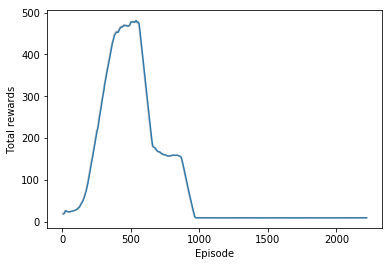

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

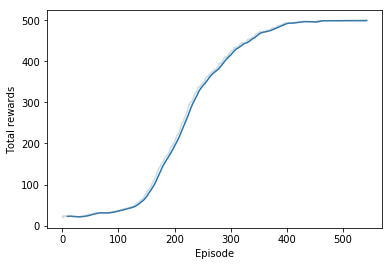

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

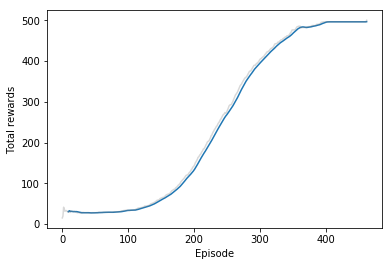

In [21]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

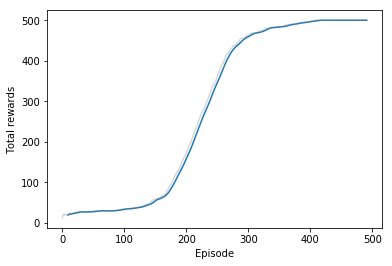

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

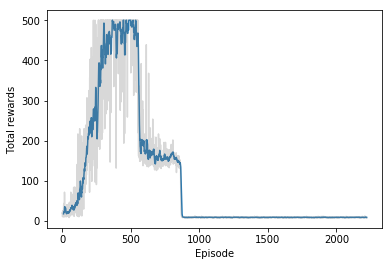

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

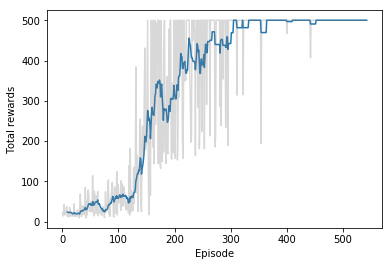

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

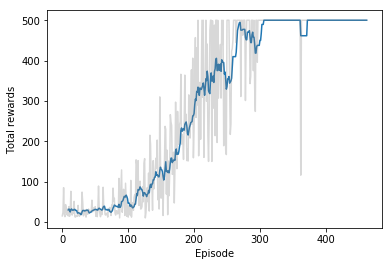

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

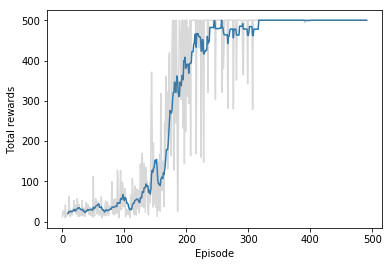

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.